<a href="https://colab.research.google.com/github/Sahil-18/Memes_Vs_Notes/blob/master/Numpy_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import PIL
from PIL import Image
from scipy import ndimage
import math

%matplotlib inline

In [ ]:
# Sigmoid Function
# function input is 'X'
# function return an array

def sigmoid(x):
  s = 1/(1+np.exp(-x))
  return s,x

In [ ]:
# Sigmoid derivative function
# Function input is 'X'
# function returns an array of 'ds'

def sigmoid_backward(dA,x):
  s = 1/(1+np.exp(-x))
  ds = np.multiply(dA,(np.array(s)*np.array(1-s)))
  return ds

In [ ]:
# Relu function 
# function input is 'X'
# function return an array

def relu(z):
  s=np.maximum(z,0)
  return s, z

In [ ]:
# Relu derivative function
# function input is 'X'
# function returns an array of 'ds'

def relu_backward(dA,z):
  s=np.maximum(z,0)
  p=s>0
  return np.multiply(dA,p)

In [ ]:
# Initializing parameters for L layer network
# function input is 'layer_dims' which has information about no of nuerons in given layer
# function return 'parameters', 'momentum', 'RMSprop' dictionary

def initialize_parameters_L_layers(layer_dims):
  np.random.seed(3)
  parameters = {}
  momentum={}
  RMSprop={}
  L = len(layer_dims) 

  for l in range(1,L):
    parameters['W'+str(l)]=np.random.randn(layer_dims[l],layer_dims[l-1])*np.sqrt(2/layer_dims[l-1])
    parameters['b'+str(l)]=np.zeros((layer_dims[l],1))
    momentum['VdW'+str(l)]=np.zeros((layer_dims[l],layer_dims[l-1]))
    momentum['Vdb'+str(l)]=np.zeros((layer_dims[l],1))
    RMSprop['SdW'+str(l)]=np.zeros((layer_dims[l],layer_dims[l-1]))
    RMSprop['Sdb'+str(l)]=np.zeros((layer_dims[l],1))

  return parameters, momentum, RMSprop

In [ ]:
# Linear forward function
# function inputs are Activation from previous layer, W, b
# function returns Z and cache that contains (A,W,b) which is received by Z and linear_cache

def linear_forward(A,W,b):
  Z=np.dot(W,A)+b
  cache=(A,W,b)
  
  return Z,cache

In [ ]:
# Linear activatoin forward function
# function inputs are Activation from previous layer, W, b , activation
# function returns A and cache that contains linear cache and linear activation cache
# linear activation cache contain z value which activation function returns

def linear_activation_forward(A_prev,W,b,activation):
  if activation=='sigmoid':
    Z,linear_cache=linear_forward(A_prev,W,b)
    A,linear_activation_cache=sigmoid(Z)
  elif activation=='relu':
    Z,linear_cache=linear_forward(A_prev,W,b)
    A,linear_activation_cache=relu(Z)

  cache=(linear_cache,linear_activation_cache)

  return A, cache

In [ ]:
# L layer linear forward function
# function inputs are 'X' and 'parameters'
# function returns AL and caches. Caches contains all linear cache and linear activatonn cache.

def L_model_forward(X,parameters):
  caches=[]
  A=X
  L= len(parameters)//2

  for l in range(1,L):
    A_prev=A
    A, cache=linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],activation='relu')
    caches.append(cache)

  AL, cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],activation='sigmoid')
  caches.append(cache)

  return AL, caches

In [ ]:
# cost computation function 
# function inputs are AL and Y
# function returns cost 

def cost_compute(AL,Y):
  m=Y.shape[1]
  cost = -np.sum(np.multiply(np.log(AL),Y)+np.multiply(np.log(1-AL),(1-Y)))/m
  cost=np.squeeze(cost)

  return cost

In [ ]:
# cost computation using regularization
# function inputs are AL,Y,parameters,lambd
# function returns cost

def regularization_cost_compute(AL,Y,parameters,lambd):
  m=Y.shape[1]
  L=len(parameters)//2
  L2_regularization_cost=0

  for l in range(1,L):
    L2_regularization_cost += np.sum(np.square(parameters['W'+str(l)]))

  L2_regularization_cost=L2_regularization_cost*lambd/(2*m)
  cross_entropy_cost=cost_compute(AL,Y)
  cost=cross_entropy_cost+L2_regularization_cost

  return cost

In [ ]:
# linear backwar function
# function inputs are dZ, cache where dZ is Gradient of cost with respect to linear output of current layer l and cache contains A_prev, W,b i.e linear cache for this layer.
# function returns dA_prev,dW,db

def linear_backward(dZ,cache):
  A_prev,W,b =cache
  m=A_prev.shape[1]

  dW=1/m*np.dot(dZ,A_prev.T)
  db=1/m*np.sum(dZ,axis=1,keepdims=True)
  dA_prev=np.dot(W.T,dZ)

  return dA_prev,dW,db


In [ ]:
# linear activation backward function 
# function inputs are dA, cache where is dA is Gradient of cost with respect to activation output of current layer l and cache contain linear and activation cache of given layer l.
# function returns dA_prev,dW,db

def linear_activation_backward(dA,cache,activation):
  linear_cache, activation_cache=cache

  if activation=='relu':
    dZ=relu_backward(dA,cache[1])
    dA_prev, dW, db=linear_backward(dZ,cache[0])
  elif activation=='sigmoid':
    dZ=sigmoid_backward(dA,cache[1])
    dA_prev, dW, db = linear_backward(dZ, cache[0])

  return dA_prev,dW,db

In [ ]:
# L layer backward function
# function inputs are AL,Y,caches
# function returns grads which contains all gradients

def L_model_backward(AL,Y,caches):
  grads={}
  L=len(caches)
  m=AL.shape[1]
  Y=Y.reshape(AL.shape)
  
  dAL = -(np.divide(Y,AL)-np.divide(1-Y,1-AL))          # we don't include dAL in grads since is it of no use afterwards

  current_cache=caches[L-1]
  grads['dA'+str(L-1)],grads['dW'+str(L)],grads['db'+str(L)]=linear_activation_backward(dAL,current_cache,'sigmoid')

  for l in reversed(range(L-1)):
    current_cache=caches[l]
    dA_prev_temp,dW_temp,db_temp=linear_activation_backward(grads['dA'+str(l+1)],current_cache,'relu')
    grads['dA'+str(l)]=dA_prev_temp
    grads['dW'+str(l+1)]=dW_temp
    grads['db'+str(l+1)]=db_temp

  return grads

In [ ]:
# Adam optimization function
# function inputs are momentum,RMSprop,grads, beta1, beta2, and number of epoch
# function outputs are momentum, RMSprop

def AdamOptimization(momentum,RMSprop,grads,beta1,beta2,epoch):
  L=len(grads)
  epoch=1

  for l in range(1,L):
    momentum['VdW'+str(l)]=beta1*momentum['VdW'+str(l)]+(1-beta1)*grads['dW'+str(l)]
    momentum['Vdb'+str(l)]=beta1*momentum['Vdb'+str(l)]+(1-beta1)*grads['db'+str(l)]

    momentum['VdW'+str(l)]=momentum['VdW'+str(l)]/(1-beta1**epoch)
    momentum['Vdb'+str(l)]= momentum['Vdb'+str(l)]/(1-beta1**epoch)

    RMSprop['SdW'+str(l)]=beta2*RMSprop['SdW'+str(l)]+(1-beta2)*(grads['dW'+str(l)]**2)
    RMSprop['Sdb'+str(l)]=beta2*RMSprop['Sdb'+str(l)]+(1-beta2)*(grads['db'+str(l)]**2)

    RMSprop['SdW'+str(l)]=RMSprop['SdW'+str(l)]/(1-beta2**epoch)
    RMSprop['Sdb'+str(l)]=RMSprop['Sdb'+str(l)]/(1-beta2**epoch)
    epoch +=1 

    return momentum,RMSprop

In [ ]:
# update parameters function
# function inputs are parameters,momentum,RMSprop,learning rate,epsilon,lambd,AL
# function returns updated parameters

def parameters_update(parameters,momentum,RMSprop,learning_rate,epsilon,lambd,AL):
  L=len(parameters)//2
  m=AL.shape[1]

  for l in range(L):
     parameters["W" + str(l+1)] = parameters["W" + str(l+1)]*(1-learning_rate*lambd/m) - learning_rate * momentum["VdW" + str(l+1)] /(np.sqrt(RMSprop["SdW" + str(l+1)])+epsilon)
     parameters["b" + str(l+1)] = parameters["b" + str(l+1)]*(1-learning_rate*lambd/m) - learning_rate * momentum["Vdb" + str(l+1)] /(np.sqrt(RMSprop["Sdb" + str(l+1)])+epsilon)

  return parameters

In [ ]:
# Predict function
# Function inputs are X and parameters 
# function returns an predictions array

def predict(X, Y, parameters):
  m=X.shape[1]
  AL, cache = L_model_forward(X,parameters)
  predictions=AL>0.5
  print ('Accuracy: %d' % float((np.dot(Y,AL.T) + np.dot(1-Y,1-AL.T))/float(Y.size)*100) + '%')
  return predictions 
  


L Layer Model function

function inputs are X, Y, layer_dims, learning_rate, num_interations, lambd, beta1, beta2, epsilon, print_cost

function returns parameters for further use



In [ ]:
def L_Layer_model(X,Y,layer_dims,learning_rate=0.001,num_iteration=10,lambd=0.1,beta1=0.9,beta2=0.999,epsilon=1e-8,print_cost=False):
  np.random.seed(1)
  costs=[]   # take care of cost per iteration

  # initialize parameters
  parameters, momentum ,RMSprop=initialize_parameters_L_layers(layer_dims)
  epoch=1

  #starting the loop
  for i in range(0,num_iteration):
  
    # forward propagation (Linear - relu) for (L-1)layers and (Linear - sigmoid) for L th layer
    AL,caches = L_model_forward(X,parameters)

    # cost computation
    cost= regularization_cost_compute(AL,Y,parameters,lambd)

    # Backpropagation
    grads=L_model_backward(AL,Y,caches)

    # Adam Optimization 
    momentum,RMSprop=AdamOptimization(momentum, RMSprop,grads,beta1,beta2,epoch)
    epoch = epoch+1

    # parameters Update
    parameters=parameters_update(parameters,momentum,RMSprop,learning_rate,epsilon,lambd , AL)

    # cost printing
    if print_cost:
      print ("Cost after iteration %i: %f" %(i, cost))
      costs.append(cost)

  # cost function plot
  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('num_interation')
  plt.title('learning_rate='+str(learning_rate))
  plt.show

  return parameters

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import os
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
memes_0 = os.listdir("/content/gdrive/My Drive/Stage 3/meme")   # Data link of memes stored at drive
memes_total = len(memes_0)
notes_0 = os.listdir("/content/gdrive/My Drive/Stage 3/note")   # Data link of notes stored at drive
notes_total = len(notes_0)

In [5]:
X_meme=[]
Y_meme=[]
i=0
for meme in memes_0:
  clear_output(wait=True)
  r_path=f'/content/gdrive/My Drive/Stage 3/meme/{meme}'      # Data link of memes stored at drive
  image=np.array(Image.open(r_path))
  X_meme.append(image)
  Y_meme.append(1)
  i += 1
  print(f"Progress: {i}/{memes_total}", flush=True)

Progress: 800/800


In [6]:
X_note=[]
Y_note=[]
i=0
for note in notes_0:
  clear_output(wait=True)
  w_path=f'/content/gdrive/My Drive/Stage 3/note/{note}'     # Data link of notes stored at drive
  image=np.array(Image.open(w_path))
  X_note.append(image)
  Y_note.append(0)
  i += 1
  print(f"Progress: {i}/{notes_total}", flush=True)

Progress: 800/800


In [ ]:
X_meme=np.array(X_meme)
Y_meme=np.array(Y_meme)

X_note=np.array(X_note)
Y_note=np.array(Y_note)

In [ ]:
# Input Output parameters defining
# function Inputs are X_meme,X_note,Y_meme,Y_note
# function returns x_train,x_dev,x_test,y_train,y_dev,y_test

def Input_parameters(X_meme,X_note,Y_meme,Y_note):
  from sklearn .model_selection import train_test_split
  x_meme_train, x_meme_test, y_meme_train, y_meme_test = train_test_split(X_meme,Y_meme,test_size =0.25,random_state = 50)
  x_meme_dev, x_meme_test, y_meme_dev, y_meme_test = train_test_split(x_meme_test,y_meme_test,test_size =0.5,random_state = 50)
  x_note_train, x_note_test, y_note_train, y_note_test = train_test_split(X_note,Y_note,test_size =0.25,random_state = 50)
  x_note_dev, x_note_test, y_note_dev, y_note_test = train_test_split(x_note_test,y_note_test,test_size =0.5,random_state = 50)

  x_test=x_meme_test+x_note_test
  x_train=x_meme_train+x_note_train
  x_dev=x_meme_dev+x_note_dev
  y_test=y_meme_test+y_note_test
  y_train=y_meme_train+y_note_train
  y_dev=y_meme_dev+y_note_dev

  np.random.seed(3)
  np.random.shuffle(x_train)
  np.random.seed(3)
  np.random.shuffle(y_train)
  np.random.seed(3)
  np.random.shuffle(x_dev)
  np.random.seed(3)
  np.random.shuffle(y_dev)
  np.random.seed(3)
  np.random.shuffle(x_test)
  np.random.seed(3)
  np.random.shuffle(y_test)

  return x_train,x_dev,x_test,y_train,y_dev,y_test

In [ ]:
x_train,x_dev,x_test,y_train,y_dev,y_test=Input_parameters(X_meme,X_note,Y_meme,Y_note)

In [ ]:
# y function reshape
# function inputs are y_train,y_dev,y_test
# function returns y_train,y_dev,y_test

def y_reshape(y_train,y_dev,y_test):
  y_train=y_train.reshape(1,y_train.shape[0])
  y_dev=y_dev.reshape(1,y_dev.shape[0])
  y_test=y_test.reshape(1,y_test.shape[0])

  return y_train,y_dev,y_test

In [ ]:
y_train,y_dev,y_test=y_reshape(y_train,y_dev,y_test)

In [ ]:
# X input flatten function
# function inputs are x_train,x_dev,x_test
# function returns x_train,x_dev,x_test

def x_flatten(x_train,x_dev,x_test):
  x_train=x_train.reshape(x_train.shape[0],-1).T/255
  x_dev=x_dev.reshape(x_dev.shape[0],-1).T/255
  x_test=x_test.reshape(x_test.shape[0],-1).T/255

  return x_train,x_dev,x_test

In [ ]:
x_train,x_dev,x_test=x_flatten(x_train,x_dev,x_test)

Cost after iteration 0: 0.467750
Cost after iteration 1: 0.138414
Cost after iteration 2: 0.096300
Cost after iteration 3: 0.087309
Cost after iteration 4: 0.084958
Cost after iteration 5: 0.084305
Cost after iteration 6: 0.084121
Cost after iteration 7: 0.084068
Cost after iteration 8: 0.084053
Cost after iteration 9: 0.084049
Accuracy: 94%


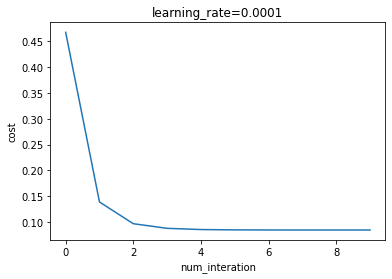

In [ ]:
parameters=L_Layer_model(x_train,y_train,layer_dims=[x_train.shape[0],100,50,25,10,5,1],learning_rate=0.0001,num_iteration=10,lambd=0.1,beta1=0.9,beta2=0.999,epsilon=1e-8,print_cost=True)
prediction=predict(x_train,y_train,parameters)

Cost after iteration 0: 1.398918
Cost after iteration 1: 0.644113
Cost after iteration 2: 0.641349
Cost after iteration 3: 0.640959
Cost after iteration 4: 0.640868
Cost after iteration 5: 0.640843
Cost after iteration 6: 0.640836
Cost after iteration 7: 0.640834
Cost after iteration 8: 0.640834
Cost after iteration 9: 0.640833
Accuracy: 99%


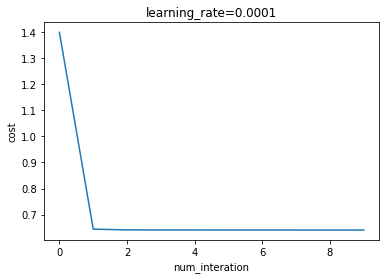

In [ ]:
parameters=L_Layer_model(x_dev,y_dev,layer_dims=[x_dev.shape[0],500,100,25,10,5,1],learning_rate=0.0001,num_iteration=10,lambd=0.1,beta1=0.9,beta2=0.999,epsilon=1e-8,print_cost=True)
prediction=predict(x_dev,y_dev,parameters)

In [ ]:
prediction = predict(x_test,y_test,parameters)

Accuracy: 99%
